In [56]:
import numpy as np
import matplotlib.pyplot as plt  

def load_dataset(file_path):
    """Load txt file to ndarray."""
    with open(file_path, 'r') as fr:
        header = fr.readline().strip().split('\t')
    
    x_col = [i for i in range(len(header) - 1)]
    y_col = [-1]    # last col is labels

    dataset = np.loadtxt(file_path, delimiter='\t', usecols=x_col)
    labels = np.loadtxt(file_path, delimiter='\t', usecols=y_col)

    return dataset, labels

def linear_regression(dataset, labels):
    """Compute the parameter theta for linear regression given dataset and labels.
    
    Args:
        dataset: ndarray of inputs, x0 = 1. Shape (m, n)
        labels: array of labels. Shape (m,)
    Returns:
        theta: array of parameters. Shape (n,)
    """
    # Normal equation for linear regression solver
    X_sq = dataset.T.dot(dataset)
    if np.linalg.det(X_sq) == 0.0:
        print('This is a singular matrix, cannot be inversed.')
        return
    else:
        theta = np.linalg.inv(X_sq).dot(dataset.T).dot(labels)
        return theta

def lr_test(file_path):
    """Load dataset and test for linear regression."""
    dataset, labels = load_dataset(file_path)
    theta = linear_regression(dataset, labels)
    print('Parameters of linear regression is {}'.format(theta))
    
    plot_model(dataset, labels, theta, 'lin_reg.png')
    
    cor = np.corrcoef(labels, dataset.dot(theta))
    print('Correlation coefficients between h(x) and y are {}'.format(cor[0, -1]))

def plot_model(dataset, labels, theta, save_path):
    """Plot the linear regression model on dataset."""
    fig, ax = plt.subplots()
    ax.scatter(dataset[:, 1], labels, s=10, c='b')
    ax.plot(dataset[:, 1], dataset.dot(theta), c='red', linewidth=1)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.savefig(save_path)
    
def lwr(dataset, labels, x, tau=1.0):
    """Train a locally weighted linear regression on dataset.
    
    Args:
        dataset: ndarray of inputs, x0 = 1. 
        labels: array of labels. 
        tau: parameter determining weights. Float number
        x: the input x to be predicted, ndarray
    Returns:
        y: predicted value for input x. array
    """
    m, n = x.shape
    y = np.zeros(m)

    for i in range(m):
        W = np.diag(np.exp(-np.sum((dataset - x[i]) ** 2, axis=1) / (2 * tau ** 2)))
        theta = np.linalg.inv(dataset.T.dot(W).dot(dataset)).dot(dataset.T).dot(W).dot(labels)
        y[i] = theta.dot(x[i])
    
    return y

def lwr_test(file_path, tau_list):
    """Load dataset and test for locally weighted linear regression."""
    dataset, labels = load_dataset(file_path)
#     tau_list = [0.003, 0.01, 0.05, 0.1, 1]     # tau near 0.001 can cause exp overflow

    for tau in tau_list:
        y_pred = lwr(dataset, labels, dataset[:], tau)    
        print('LWR with tau: {}'.format(tau))
        print('Inputs: {}, predictions: {}'.format(dataset[:5], y_pred[:5]))    # test the first 5 examples in dataset
        
        fig, ax = plt.subplots()
        ax.scatter(dataset[:, 1], labels, s=10, c='b')
        ax.scatter(dataset[:, 1], y_pred[:], s = 5, c='r')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.savefig('lwr_{}.png'.format(tau))
        
        cor = np.corrcoef(labels, y_pred)
        print('Correlation coefficients between h(x) and y are {}'.format(cor[0, -1]))
        
        rss = calculate_rss(labels, y_pred)
        print('The RSS of this model is {}'.format(rss))
    
def calculate_rss(labels, y_pred):
    """Calculate the RSS of a given prediction."""
    return ((labels - y_pred) ** 2).sum()

def ridge_regression(dataset, labels, lam=0.2):
    """Fit Ridge Regression to the input dataset.
    
    Args:
        dataset: ndarray of inputs, x0 = 1. Shape (m, n) 
        labels: array of labels. Shape (m,)
        lam: regularization parameter. Float number
    Returns:
        theta: array of model parameters. Shape (n,)
    """
    # Normal equation for linear regression solver
    X_sq = dataset.T.dot(dataset) + lam * np.eye(dataset.shape[1])

    if np.linalg.det(X_sq) == 0.0:
        print('This is a singular matrix, cannot be inversed.')
        return
    else:
        theta = np.linalg.inv(X_sq).dot(dataset.T).dot(labels)
        return theta

def normalization(data):
    """Normalize a ndarray"""
    _range = np.max(data) - np.min(data)  # np.max(arr, axis=0)
    return (data - np.min(data)) / _range

def standardization(data):
    """Standardize a ndarray"""
    mean = np.mean(data, axis=0)
    sd = np.std(data, axis=0)
    return (data - mean) / sd

def ridreg_test(train_path, save_path):
    """Test for ridge regression."""
    dataset, labels = load_dataset(train_path)
#     norm_datset = normalization(dataset)
#     norm_labels = normalization(labels)
    std_dataset = standardization(dataset)
    std_labels = labels - np.mean(labels)

    num_tests = 30
    theta_mat = np.zeros((num_tests, dataset.shape[1]))

    for i in range(num_tests):
        theta_mat[i] = ridge_regression(std_dataset, std_labels, np.exp(i - 10))

    fig, ax = plt.subplots()
    ax.plot(theta_mat)
    plt.xlabel('log(lambda)')
    plt.ylabel('theta')
    plt.savefig(save_path)

    return theta_mat

def stage_wise_regression(file_path, save_path, eps=0.01, num_iter=100):
    """Fit StageWise Linear Regression on input dataset.
    
    Args:
        file_path: path to the txt file containing dataset and labels
        eps: stepsize of parameter learning. Float number
        num_iter: number of iterations
    Returns:
        theta: array of model parameters. Shape (n,)
    """
    dataset, labels = load_dataset(file_path)
    std_dataset = standardization(dataset)
    std_labels = labels - np.mean(labels)

    m, n = dataset.shape
    theta_mat = np.zeros((num_iter, n))
    theta_prev = np.zeros(n)
    best_theta = np.zeros(n)

    for i in range(num_iter):
        min_rss = float('inf')

        for j in range(n):
            for sign in [-1, 1]:
                theta = np.copy(theta_prev)
                theta[j] += sign * eps

                y_pred = std_dataset.dot(theta)
                rss = calculate_rss(std_labels, y_pred)

                if rss < min_rss:
                    min_rss = rss
                    best_theta = theta

        theta_prev = np.copy(best_theta)
        theta_mat[i] = theta_prev

    fig, ax = plt.subplots()
    ax.plot(theta_mat)
    plt.xlabel('log(lambda)')
    plt.ylabel('theta')
    plt.savefig(save_path)
    
    return theta_mat

Parameters of linear regression is [3.00774324 1.69532264]
Correlation coefficients between h(x) and y are 0.9864735622335207


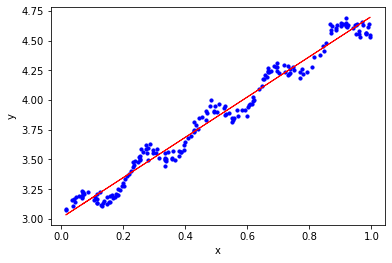

In [19]:
lr_test('ex0.txt')

LWR with tau: 0.003
Inputs: [[1.       0.067732]
 [1.       0.42781 ]
 [1.       0.995731]
 [1.       0.738336]
 [1.       0.981083]], predictions: [3.20200665 3.75940186 4.53670134 4.25050564 4.56094936]
Correlation coefficients between h(x) and y are 0.9993194545993296
The RSS of this model is 0.06865982925344667
LWR with tau: 0.01
Inputs: [[1.       0.067732]
 [1.       0.42781 ]
 [1.       0.995731]
 [1.       0.738336]
 [1.       0.981083]], predictions: [3.20366661 3.75415715 4.56556721 4.24973353 4.58577862]
Correlation coefficients between h(x) and y are 0.9985248990196387
The RSS of this model is 0.1488294894309519
LWR with tau: 0.05
Inputs: [[1.       0.067732]
 [1.       0.42781 ]
 [1.       0.995731]
 [1.       0.738336]
 [1.       0.981083]], predictions: [3.17284525 3.73736024 4.57606428 4.2568484  4.58637257]
Correlation coefficients between h(x) and y are 0.9941200466357181
The RSS of this model is 0.606602620847069
LWR with tau: 0.1
Inputs: [[1.       0.067732]
 [1.   

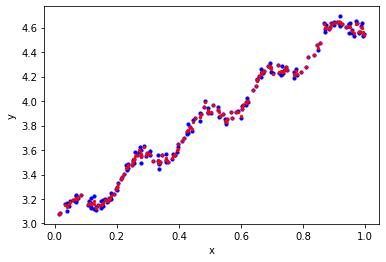

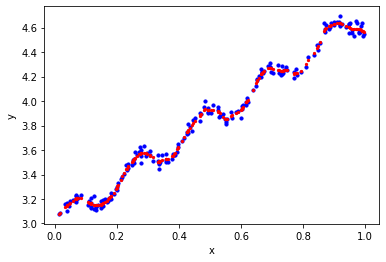

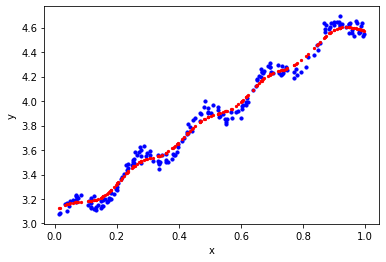

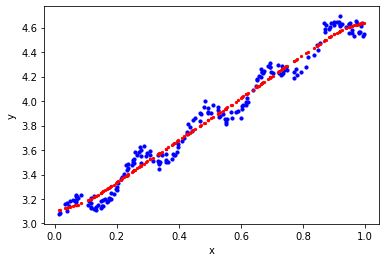

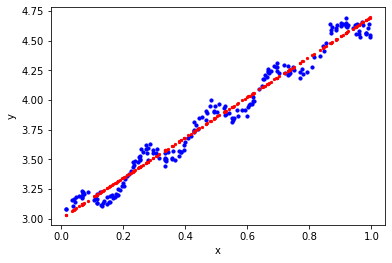

In [2]:
lwr_test('ex0.txt', [0.003, 0.01, 0.05, 0.1, 1])

In [3]:
lwr_test('abalone.txt', [0.1, 1, 10])

KeyboardInterrupt: 

array([[ 5.23561421e-02, -1.89389258e-01,  1.33168906e+00,
         4.96193251e-01,  4.53578826e+00, -4.50107523e+00,
        -1.06982553e+00,  1.19429752e+00],
       [ 5.23561140e-02, -1.89388567e-01,  1.33168818e+00,
         4.96193328e-01,  4.53577546e+00, -4.50106918e+00,
        -1.06982257e+00,  1.19430181e+00],
       [ 5.23560375e-02, -1.89386688e-01,  1.33168580e+00,
         4.96193538e-01,  4.53574065e+00, -4.50105271e+00,
        -1.06981452e+00,  1.19431346e+00],
       [ 5.23558298e-02, -1.89381581e-01,  1.33167932e+00,
         4.96194107e-01,  4.53564604e+00, -4.50100796e+00,
        -1.06979265e+00,  1.19434514e+00],
       [ 5.23552650e-02, -1.89367698e-01,  1.33166172e+00,
         4.96195656e-01,  4.53538887e+00, -4.50088632e+00,
        -1.06973319e+00,  1.19443124e+00],
       [ 5.23537298e-02, -1.89329963e-01,  1.33161388e+00,
         4.96199865e-01,  4.53468996e+00, -4.50055573e+00,
        -1.06957161e+00,  1.19466523e+00],
       [ 5.23495579e-02, -1.892274

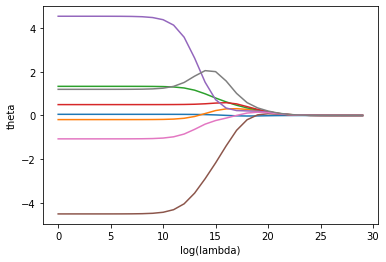

In [48]:
ridreg_test('abalone.txt', 'ridge_reg.png')

array([[ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.01],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.02],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.03],
       ...,
       [ 0.06, -0.15,  1.29, ..., -4.45, -1.05,  1.23],
       [ 0.05, -0.15,  1.29, ..., -4.45, -1.05,  1.23],
       [ 0.06, -0.15,  1.29, ..., -4.45, -1.05,  1.23]])

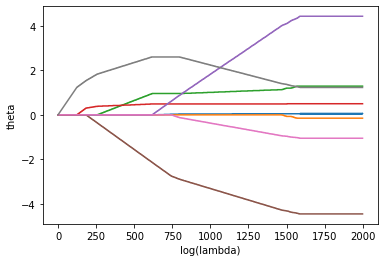

In [62]:
stage_wise_regression('abalone.txt', 'stagewise_regression_2000.png', 0.01, 2000)

In [63]:
# Comparison between stagewise regression and linear regression results
dataset, labels = load_dataset('abalone.txt')
std_dataset = standardization(dataset)
std_labels = labels - np.mean(labels)
linear_regression(std_dataset, std_labels)
# array([ 0.05235616, -0.18938966,  1.33168957,  0.49619321,  4.53579572,  -4.50107876, -1.06982725,  1.19429503])

array([ 0.05235616, -0.18938966,  1.33168957,  0.49619321,  4.53579572,
       -4.50107876, -1.06982725,  1.19429503])

In [64]:
arr1= np.array([[1, 2, 3], [1, 3, 4], [2, 3, 4]])
arr2 = standardization(arr1)

In [69]:
arr1

array([[1, 2, 3],
       [1, 3, 4],
       [2, 3, 4]])

In [91]:
np.random.shuffle(arr1.copy())
arr1

array([[1, 3, 4],
       [2, 3, 4],
       [1, 2, 3]])